### Réalisez une analyse de sentiments grâce au Deep Learning

### Présentation du projet

Air Paradis a missionné votre cabinet pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux. Il est vrai que “Air Paradis” n’a pas toujours bonne presse sur les réseaux…

En sortant d’un rendez-vous de cadrage avec les équipes de Air Paradis, vous avez noté les éléments suivants :

Air Paradis veut un prototype d’un produit IA permettant de prédire le sentiment associé à un tweet.
Données : pas de données clients chez Air Paradis. Solution : utiliser des données Open Source (ou en téléchargement direct à ce lien)
Description des données : des informations sur les tweets (utilisateur ayant posté, contenu, moment du post) et un label binaire (tweet exprimant un ent négatif ou non).                                                                                





on). 
TO-DO :
Préparer un prototype fonctionnel du modèle. Le modèle est exposé via une API déployée sur le Cloud, appelée par une interface locale (notebook ou application Streamlit) qui envoie un tweet à l’API et récupère la prédiction de sentiment. 
Préparer un support de présentation explicitant les méthodologies utilisées pour les différentes approches (attention : audience non technique).

### Importation et installation des bibliothèques

In [52]:
!pip install keras

In [53]:
!pip install tensorflow

In [2]:
!pip install transformers

  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.15.2-cp311-none-win_amd64.whl.metadata (6.8 kB)
  Using cached safetensors-0.4.2-cp311-none-win_amd64.whl.metadata (3.9 kB)
Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
Using cached safetensors-0.4.2-cp311-none-win_amd64.whl (269 kB)
Using cached tokenizers-0.15.2-cp311-none-win_amd64.whl (2.2 MB)


In [54]:
!pip install h5py

In [55]:
import spacy
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk
import gensim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import scipy.sparse
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from transformers import RobertaTokenizer, RobertaModel
from transformers import BertTokenizer
import tensorflow as tf
import mlflow.pytorch
import mlflow.keras
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

### Importer et explorer les données

In [56]:
data = pd.read_csv('projet_seven.csv', delimiter=',', header=None, skiprows=[5312], encoding='latin1')

In [57]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [58]:
# Définir une liste des nouveaux noms de colonnes
new_columns = ['Label', 'Id', 'Date', 'Query', 'name', 'Text']

# Renommer les colonnes du DataFrame
data.columns = new_columns

data.head()

,Label,Id,Date,Query,name,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Label   1599999 non-null  int64 
 1   Id      1599999 non-null  int64 
 2   Date    1599999 non-null  object
 3   Query   1599999 non-null  object
 4   name    1599999 non-null  object
 5   Text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [60]:
data.nunique()

Label          2
Id       1598314
Date      774362
Query          1
name      659775
Text     1581465
dtype: int64

In [61]:
data.isna().sum()

Label    0
Id       0
Date     0
Query    0
name     0
Text     0
dtype: int64

In [62]:
data.describe()

,Label,Id
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [63]:
data.describe(include ='O')

,Date,Query,name,Text
count,1599999,1599999,1599999,1599999
unique,774362,1,659775,1581465
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1599999,549,210


### Constitution de notre dataframe de travail

In [64]:
# choix des colonnes de nore nouveau dataframe
cols = ["Label", "Text"]
df = data[cols]
df.head()

,Label,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [65]:
df.shape

(1599999, 2)

In [66]:
df.isna().mean()

Label    0.0
Text     0.0
dtype: float64

### Prétraitement et analyse de la variable "Label"

La variable "Label" est notre variable target.

0 signifie que le tweet est classé négatif et 4 signifie que le tweet est annoté poistif.

Le 0 sera maintenu 0 et signifiera toujours que le tweet est classé négatif. 

En revanche le 4 sera ramplacé par 1 car c'est plus conventionnel.

Désormais, le label 1 signifie que le tweet est classé positif.

In [67]:
# Remplacer les labels dans la colonne Label
df['Label'] = df['Label'].replace({0: 0, 4: 1})


In [68]:
# Pour les valeurs dupliquées
idx = df.duplicated(subset="Text", keep= "first")
df.loc[idx, : ].sort_values("Text")

,Label,Text
271504,0,David must be hospitalized for five days end...
1132075,1,bathroom is clean..... now on to more enjoya...
540172,0,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364946,1,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331062,0,*tear*
...,...,...
1375801,1,youtube.
256596,0,yuckkk its pouring rain &amp; im filthy now!! ...
458169,0,"zofran is not making this work day any easier,..."
464809,0,~ get SUICIDE !!


Nous avons 18534 valeurs dupliquées. Celles-ci seront supprimées.

In [69]:
# Supprimer les valeurs dupliquées en se basant sur la colonne "Text"
df = df.drop_duplicates(subset="Text", keep="first")

In [70]:
df.Label.value_counts()

Label
1    791281
0    790184
Name: count, dtype: int64

<Axes: ylabel='count'>

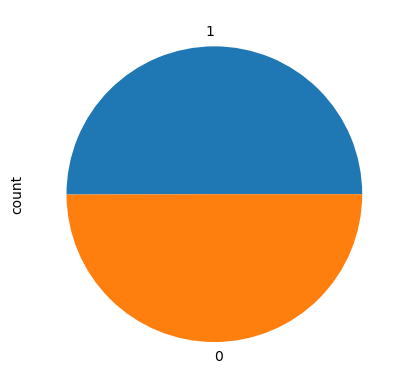

In [71]:
df.Label.value_counts().plot(kind='pie')

La distribution des labels est équilibrée.

### Analyse de la variable "Text"

In [72]:
# Nombre de caractéres par observation
df.Text.apply(lambda i : len(i))

0          115
1          111
2           89
3           47
4          111
          ... 
1599994     56
1599995     78
1599996     57
1599997     65
1599998     62
Name: Text, Length: 1581465, dtype: int64

<Axes: >

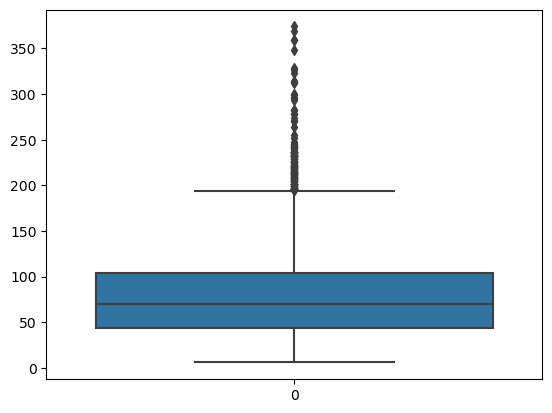

In [73]:
len_text = df.Text.str.len()
sns.boxplot(len_text)

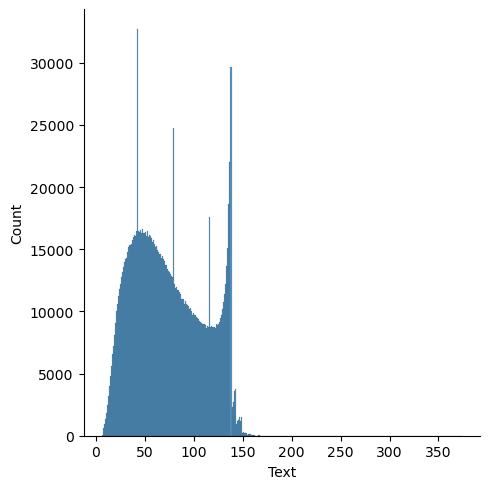

In [74]:
sns.displot(len_text)

La majeur partie des tweets comprend moins de 150 caractères.
Il existe, néanmoins, quelques valeurs abérantes qu'il convient de supprimer car les tweets trop longs peuvent affecter la cohérence des données et n'ideraient pas le modèle à se concentrer sur les informations les plus pertinentes.

In [75]:
# Filtrer les tweets ayant 3 caractères ou moins et les tweets de plus de 200 caractères
df = df[(df['Text'].apply(lambda x: len(x) > 3)) & (df['Text'].apply(lambda x: len(x) <= 200))]

<Axes: >

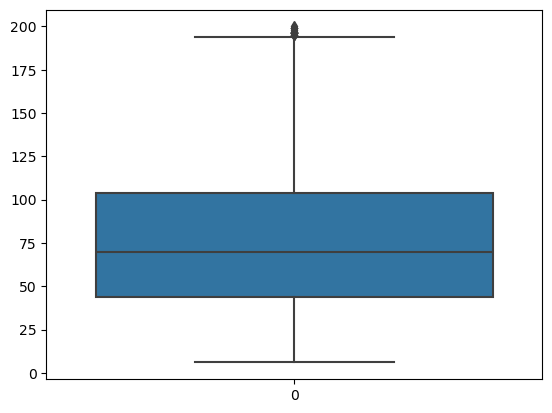

In [76]:
len_text = df.Text.str.len()
sns.boxplot(len_text)

In [77]:
df.shape

(1581339, 2)

In [78]:
# Enregistrement du dataframe
df.to_csv("df_kaggle.csv", index=False)

### Explorer superficiellement le corpus

In [79]:
df_samp = df.sample(20)
df_samp

,Label,Text
128086,0,@aminahibrahim ; the others get a head start b...
300735,0,"My stomach hurts. Nothing new, but still pain..."
1052678,1,@tazzman61 can send anything bill..
1021951,1,@fuzzym Dream Chronicles 3. Game I got into a ...
991517,1,@MaggieProctor We should celebrate an unbirth...
1423166,1,out at barn this am. Shawn threw a shoe but d...
47260,0,Really need to stop talkin to jugs and slip i'...
100745,0,Found a rabbit nest last night after dogs kill...
792412,0,@funkyfannys omg... SO not edible- and worse t...
1462715,1,@Julesurich Thanks again for coming to Hawaii ...


In [80]:
# J'imprime 20 descriptions au hasard
for idx, ser in df_samp.iterrows():
    txt = f"label : {ser['Label']}\n"
    print(txt + ser['Text'] + "..." + "\n\n")

label : 0
@aminahibrahim ; the others get a head start because they learnt the fast methods from Mr K last year. ...


label : 0
My stomach hurts.  Nothing new, but still painful. ...


label : 1
@tazzman61 can send anything bill.. ...


label : 1
@fuzzym Dream Chronicles 3. Game I got into a couple years back on Mac that they've released in episodes. bigfishgame.com Check it out ...


label : 1
@MaggieProctor  We should celebrate an unbirthday soon. A good reason for cake ...


label : 1
out at barn this am.  Shawn threw a shoe but did great in his lesson until then.  It was a little chilly had to wear a jacket!  ...


label : 0
Really need to stop talkin to jugs and slip i'm obviously umm young for them...  ...


label : 0
Found a rabbit nest last night after dogs killed their mother. Two bunnies in the nest, one ran away but other has broken leg or back. ...


label : 0
@funkyfannys omg... SO not edible- and worse than crusty crumbs-  tobacco leaves and lip gloss  my purse is gross!

L'exploration de 20 descriptions au hazard donne des résultats satisfaisants en terme de cohérence des description avec les catégories assignées. 

### Séléction d'un échantillion aléatoire de travail

In [81]:
# Sélectionner un échantillon aléatoire de travail
df_work = df.sample(n=20000, random_state=42)  # Sélectionne 100000 lignes aléatoires du DataFrame

### Custom stop words

La liste stopwords de Nltk étant générique, il convient de personnaliser notre propre liste de stopwords.

La stratégie sera d'éliminer les tokens qui sont des signes de ponctuation et dont la longueur est inférieure à 3 caractères. Nous éliminons, par la suite, les 15 mots les plus fréquents ainsi que les mots ayant une faible occurrence (1 apparition), je supprime aussi les mots ayants au moins un caractère numérique.

La raison étant d'ajouter à notre liste de stopwords personnalisée tous les mots ayant un faible pouvoir informatif et dont la présence peut augmenter la complexité du modèle sans qu'il y ait de bénéfices en retour.

In [82]:
# Création du corpus sur la colonne description
print("Création du corpus sur la colonne description...")
corpus = " ".join(df_work['Text'].values)

# Tokenization et enlèvement des stopwords anglais
print("Tokenization et enlèvement des stopwords anglais...")
tokens = word_tokenize(corpus.lower())
stop_words = set(nltk_stopwords.words('english'))
tokens = [w for w in tokens if w not in stop_words]

# Lemmatisation
print("Lemmatisation des tokens...")
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Enlèvement de la ponctuation et des mots courts
print("Enlèvement de la ponctuation et des mots courts...")
tokens = [token for token in tokens if token not in string.punctuation and len(token) >= 3]

# Création d'un DataFrame contenant les mots uniques et leur fréquence
print("Création d'un DataFrame contenant les mots uniques et leur fréquence...")
word_freq = Counter(tokens)
freq_word = pd.DataFrame({'Mots': list(word_freq.keys()), 'Apparition': list(word_freq.values())})
freq_word_sorted = freq_word.sort_values(by='Apparition', ascending=False)

# Sélection des 30 mots les plus fréquents
print("Sélection des 15 mots les plus fréquents...")
most_common_words = freq_word_sorted['Mots'].head(30).values.tolist()
print(most_common_words)

# Sélection des mots apparaissant une seule fois
print("Sélection des mots apparaissant une seule fois...")
single_occurrence_words = freq_word[freq_word['Apparition'] == 1]['Mots'].tolist()

# Création de la liste personnalisée de stopwords
print("Création de la liste personnalisée de stopwords...")
custom_stop_words = most_common_words + single_occurrence_words + list(stop_words)
custom_stop_words = set(custom_stop_words)

# Ajout des tokens numériques à la liste de stopwords personnalisée
numeric_tokens = [token for token in tokens if token.isdigit()]
tokens_with_numeric_value = [token for token in tokens if any(char.isdigit() for char in token)]
custom_stop_words.update(set(numeric_tokens))
custom_stop_words.update(set(tokens_with_numeric_value))

print(f"Nombre de mots total dans la liste custom_stop_words : {len(custom_stop_words)}")

# Affichage de la fréquence d'apparition des mots dans l'ordre décroissant
print("Affichage de la fréquence d'apparition des mots dans l'ordre décroissant :")
freq_word_sorted = freq_word.sort_values(by='Apparition', ascending=False)
print(freq_word_sorted.head(20))  # Affichage des 20 premières lignes pour un aperçu

Création du corpus sur la colonne description...
Tokenization et enlèvement des stopwords anglais...
Lemmatisation des tokens...
Enlèvement de la ponctuation et des mots courts...
Création d'un DataFrame contenant les mots uniques et leur fréquence...
Sélection des 15 mots les plus fréquents...
['...', "n't", 'day', 'good', 'get', 'like', 'quot', 'today', 'http', 'love', 'got', 'work', 'going', 'lol', 'time', 'one', 'back', 'know', 'want', 'really', 'night', 'see', 'amp', 'think', "'ll", 'thanks', 'well', 'still', 'home', 'new']
Sélection des mots apparaissant une seule fois...
Création de la liste personnalisée de stopwords...
Nombre de mots total dans la liste custom_stop_words : 22498
Affichage de la fréquence d'apparition des mots dans l'ordre décroissant :
       Mots  Apparition
6       ...        2787
71      n't        2140
62      day        1274
59     good        1125
186     get        1052
208    like        1036
31     quot         921
267   today         910
11     http 

### Words cloud

Generating word cloud for category: 0
Step 1: Tokenizing and lemmatizing the text...
Step 2: Generating word cloud...
Step 3: Plotting word cloud...


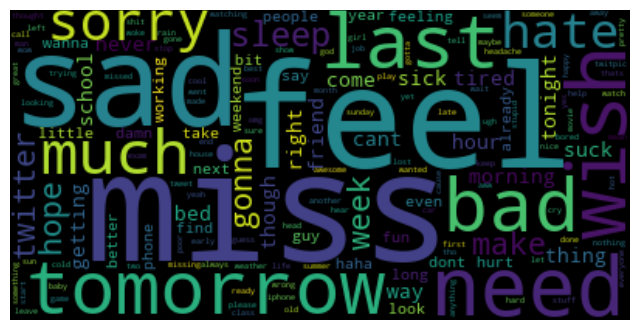

Generating word cloud for category: 1
Step 1: Tokenizing and lemmatizing the text...
Step 2: Generating word cloud...
Step 3: Plotting word cloud...


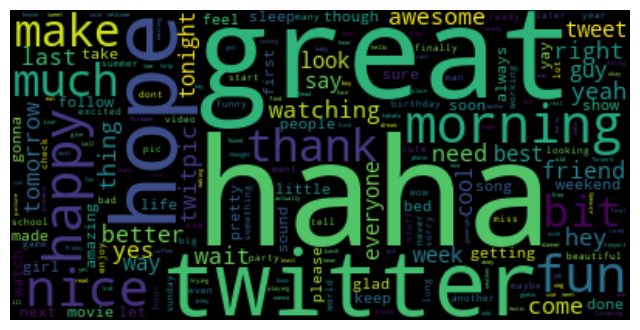

In [83]:
# Définir la fonction generate_wordcloud avec les paramètres requis
def generate_wordcloud(text, custom_stop_words=None, collocations=False, normalize_plurals=True, include_numbers=False, min_word_length=3):
    

    print("Step 1: Tokenizing and lemmatizing the text...")
    # Tokenize the text using NLTK's WordPunctTokenizer
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove custom stopwords, punctuation, and numbers
    tokens = [token for token in tokens if token not in custom_stop_words]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if len(token) >= min_word_length]
    if not include_numbers:
        tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    # Join the filtered tokens to form a clean text
    cleaned_corpus = ' '.join(tokens)

    print("Step 2: Generating word cloud...")
    # Generate word cloud with specified parameters
    wordcloud_params = {
        'collocations': collocations,
        'normalize_plurals': normalize_plurals,
        'include_numbers': include_numbers,
        'min_word_length': min_word_length,
        'stopwords': None
    }

    # Generate word cloud
    wordcloud = WordCloud(**wordcloud_params).generate(cleaned_corpus)

    print("Step 3: Plotting word cloud...")
    # Plot word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Grouper les textes par catégorie
grouped = df_work.groupby('Label')['Text'].apply(' '.join)

# Appliquer generate_wordcloud à chaque groupe de textes
for category, text in grouped.items():
    print(f"Generating word cloud for category: {category}")
    generate_wordcloud(text, custom_stop_words=custom_stop_words)  # Utilisation de la liste custom_stop_words

### Prétraitement de la variable "Text"

#### Lemmatization

In [84]:
# Fonction pour lemmatiser le texte en tenant compte des mots vides personnalisés
def lemmatize_text(text, stop_words):
    # Tokenization et enlèvement des stopwords 
    tokens = word_tokenize(text.lower())
    stop_words = custom_stop_words
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatisation avec NLTK
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens
                         if (token not in custom_stop_words
                             and token not in string.punctuation
                             and not token.isdigit()
                             and len(token) >= 3)]
    return ' '.join(lemmatized_tokens)


# Appliquer la fonction à la colonne 'description' de final_df
df_work['text_cleaned'] = df_work['Text'].apply(lambda x: lemmatize_text(x, custom_stop_words))

#### Stemming

In [85]:
# Fonction de stemming
def stem_text(text, custom_stop_words):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Initialisation du stemmer
    stemmer = PorterStemmer()

    # Stemming de chaque token
    stemmed_tokens = [stemmer.stem(token) for token in tokens
                      if (token not in custom_stop_words
                          and token not in string.punctuation
                          and not token.isdigit()
                          and len(token) >= 3)]

    # Joindre les tokens stemmés en une seule chaîne de texte
    stemmed_text = ' '.join(stemmed_tokens)

    return stemmed_text

# Appliquer la fonction de stemming à la colonne 'text' de votre DataFrame
df_work['text_stemmed'] = df_work['Text'].apply(lambda x: stem_text(x, custom_stop_words))

In [86]:
df_work

,Label,Text,text_cleaned,text_stemmed
1419043,1,OMG! To miss this warehouse sale would be a TR...,omg miss warehouse sale would tragedy april early,omg miss warehous sale would tragedi april earli
412032,0,I think i hurt my hand,hurt hand,hurt hand
86156,0,hey guys can some 1 add me please i need some ...,hey guy add please need friend,hey guy add pleas need friend
1135069,1,Dena you may use my laptop now,may use laptop,may use laptop
243858,0,"@allyheartsbb yeah, probably that is more nece...",yeah probably necessary parent college recently,yeah probabl necessari parent colleg recent
...,...,...,...,...
466157,0,@shilpig yes.. wanted to tell you but always r...,yes wanted tell always remembered hanging phone,ye want tell alway rememb hang phone
502215,0,@markhoppus and Mexico when? please!!! plase!...,markhoppus mexico please mexico love mexican f...,markhoppu mexico pleas mexico love mexican foo...
411402,0,@eazid: Darn @givemecherrypom We missed the #F...,darn missed firework billy bowleg pirate festi...,darn miss firework billi bowleg pirat festiv w...
539177,0,ugh i have a will to draw but no ideas,ugh draw idea,ugh draw idea


### Logistic Regression avec TF-Idf

#### Avec lemmatisation

In [87]:
# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_cleaned"], df_work["Label"], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_lemm = vectorizer.fit_transform(X_train)
X_test_lemm = vectorizer.transform(X_test)
X_train_lemm = X_train_lemm.toarray()
X_test_lemm = X_test_lemm.toarray()


# Instancier l'expérimentation MLFlow
mlflow.set_experiment("Reg_Logistic_Model")
mlflow.sklearn.autolog()


# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_defaut"):
    model = LogisticRegression()
    model.fit(X_train_lemm, y_train)
    


2024/04/08 00:14:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 945. MiB for an array with shape (123904000,) and data type float64


In [88]:
!pip install pyngrok

In [90]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Settings the authtoken
NGROK_AUTH_TOKEN = '2eZ0udf84vN7Xjnxou0LadI0XUj_39Cuq8i5bZmtoih5hkoWy'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls= True)
print('MLflow Tracking UI:', ngrok_tunnel.public_url)

MLflow Tracking UI: https://b2e9-2a01-e0a-b7f-6c80-d0d5-2e36-4e75-c1d0.ngrok-free.app


ERROR:pyngrok.process.ngrok:t=2024-04-09T03:55:32+0200 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=074eef1b07d8 clientid=040d3cd08385a656d784355644a0c57f
ERROR:pyngrok.process.ngrok:t=2024-04-09T03:55:32+0200 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=22568f446de9 err="session closed"
ERROR:pyngrok.process.ngrok:t=2024-04-09T03:55:33+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
ERROR:pyngrok.process.ngrok:t=2024-04-09T03:55:33+0200 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
ERROR:pyngrok.process.ngrok:t=2024-04-09T18:02:19+0200 lvl=eror msg="heartbeat timeout, terminating session"

In [91]:
!mlflow ui

^C


In [92]:
# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_max_iter200"):
    model_2 = LogisticRegression(max_iter = 200)
    model_2.fit(X_train_lemm, y_train)

2024/04/08 00:15:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 945. MiB for an array with shape (123904000,) and data type float64


In [93]:
# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_lemm_max_iter400"):
    model_3 = LogisticRegression(max_iter = 400)
    model_3.fit(X_train_lemm, y_train)

2024/04/08 00:16:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 945. MiB for an array with shape (123904000,) and data type float64


#### Avec stemming

In [94]:
# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_stemmed"], df_work["Label"], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_stem = vectorizer.fit_transform(X_train)
X_test_stem = vectorizer.transform(X_test)

# Instancier l'expérimentation MLFlow
mlflow.set_experiment("Reg_Logistic_Model")
mlflow.sklearn.autolog()


# Créer et entraîner un modèle de régression logistique
with mlflow.start_run(run_name =  "reg_logistic_stemm_defaut"):
    model = LogisticRegression()
    model.fit(X_train_stem, y_train)
    

2024/04/08 00:16:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


In [97]:
import torch

# Vider la mémoire allouée par PyTorch (fonctionne également sur CPU)
torch.cuda.empty_cache()

### LSTM avec Word2Vec

In [98]:
from keras.layers import Embedding
def create_layer_embedding_word_2_vec(X, W2V_SIZE=300, W2V_WINDOW=7, W2V_EPOCH=32, W2V_MIN_COUNT=10, SEQUENCE_LENGTH=300, workers=32):
    documents = [text.split() for text in X]
    w2v_model = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=workers, epochs=W2V_EPOCH)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE, trainable=False)

    
    return embedding_layer_word_2_vec


In [100]:
def get_model_lstm_embedding_pretrain(embedding, printing=False, metric=['accuracy', tf.keras.metrics.AUC()]):
    model = Sequential()
    model.add(embedding)
    print("Embedding layer added.")
    model.add(Dropout(0.1))
    print("Dropout layer added.")
    model.add(Bidirectional(LSTM(64)))
    print("Bidirectional LSTM layer added.")
    model.add(Dropout(0.2))
    print("Dropout layer added.")
    model.add(Dense(1, activation='sigmoid'))
    print("Dense layer added.")
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metric)
    return model

# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_cleaned"], df_work["Label"], test_size=0.2, random_state=42)
    
embedding = create_layer_embedding_word_2_vec(X_train)
print("Embedding layer created.")

model = get_model_lstm_embedding_pretrain(embedding, printing=True)
print("Model created.")

# Tokeniser les textes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print("Tokenizer fitted on training data.")

# Définition du chemin de l'expérience MLflow
mlflow.set_experiment("Bidirectional_LSTM")

# Début de l'exécution MLflow
with mlflow.start_run(run_name =  "LSTM_Word2vec"):
    # Convertir les textes en séquences d'entiers
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    print("Training data converted to sequences.")

    # Remplir les séquences pour qu'elles aient toutes la même longueur
    SEQUENCE_LENGTH = 300
    X_train_padded = pad_sequences(X_train_sequences, maxlen=SEQUENCE_LENGTH)
    print(f"Training data padded to length {SEQUENCE_LENGTH}.")

    # Entraîner le modèle avec les vecteurs d'incorporation
    history = model.fit(X_train_padded, y_train, batch_size=32, epochs=5, validation_split=0.2)
    print("Model trained.")

    # Enregistrement des métriques dans MLflow
    for metric_name, metric_values in history.history.items():
        for i, metric_value in enumerate(metric_values):
            mlflow.log_metric(metric_name, metric_value, step=i)
    print("Metrics logged to MLflow.")

    # Enregistrez le modèle
    mlflow.keras.log_model(model, "Bidirectional_LSTM")
    
print(model.summary())

Embedding layer created.
Embedding layer added.
Dropout layer added.
Bidirectional LSTM layer added.
Dropout layer added.
Dense layer added.
Model created.
Tokenizer fitted on training data.
Training data converted to sequences.
Training data padded to length 300.
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 84s 198ms/step - accuracy: 0.6042 - auc_4: 0.6539 - loss: 0.6436 - val_accuracy: 0.7150 - val_auc_4: 0.7846 - val_loss: 0.5575
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.8012 - auc_4: 0.8805 - loss: 0.4377 - val_accuracy: 0.7053 - val_auc_4: 0.7760 - val_loss: 0.5873
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 87s 218ms/step - accuracy: 0.8524 - auc_4: 0.9304 - loss: 0.3387 - val_accuracy: 0.7003 - val_auc_4: 0.7624 - val_loss: 0.6591
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 231ms/step - accuracy: 0.8960 - auc_4: 0.9616 - loss: 0.2530 - val_accuracy: 0.6875 - val_auc_4: 0.7447 - val_loss: 0.7655
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 93s 231ms/step - accuracy: 0.913

2024/04/08 00:29:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Metrics logged to MLflow.


ImportError: h5py must be installed in order to save a model.

In [121]:
def test_tweets(model, tweets):
    for twt in tweets:
        print(twt)
        # Tokenisation des tweets
        twt = tokenizer.texts_to_sequences([twt])
        # Remplissage des séquences pour qu'elles aient la même longueur
        twt = pad_sequences(twt, maxlen=28, dtype='int32', padding='post', truncating='post', value=0)
        # Prédiction du sentiment
        sentiment = model.predict(twt, batch_size=1, verbose=2)[0]
        if sentiment > 0.5:
            print("Positive")
        else:
            print("Negative")

In [122]:
test_tweets(model, ['this flight was great'])

this flight was great
1/1 - 0s - 222ms/step
Positive


In [123]:
test_tweets(model, ['this flight was bad'])

this flight was bad
1/1 - 0s - 28ms/step
Positive


In [125]:
test_tweets(model, ['horrible'])

horrible
1/1 - 0s - 28ms/step
Positive


### LSTM avec Glove

In [44]:
# Créer une couche d'embedding à partir de GloVe
def create_glove_embedding_layer(embedding_file_path, tokenizer, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(embedding_file_path, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in tokenizer.word_index:
                idx = tokenizer.word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=False)
    return embedding_layer

In [45]:
# Définir les paramètres de l'embedding et du LSTM
EMBEDDING_DIM = 100  # Dimension des embeddings GloVe
SEQUENCE_LENGTH = 300
LSTM_UNITS = 100

# Spliter les données
X_train, X_test, y_train, y_test = train_test_split(df_work["text_stemmed"], df_work["Label"], test_size=0.2, random_state=42)

# Créer le tokenizer et prétraiter les données
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_glove = pad_sequences(X_train_seq, maxlen=SEQUENCE_LENGTH)
X_test_glove = pad_sequences(X_test_seq, maxlen=SEQUENCE_LENGTH)

# Créer la couche d'embedding à partir de GloVe
embedding_file_path = 'C:/Users/Dhaker/Documents/Projet_7/glove.twitter.27B.200d.txt' # Chemin vers le fichier GloVe
embedding_layer = create_glove_embedding_layer(embedding_file_path, tokenizer, vocab_size, EMBEDDING_DIM)

# Définition du chemin de l'expérience MLflow
mlflow.set_experiment("Bidirectional_LSTM")
mlflow.sklearn.autolog()

# Début de l'exécution MLflow
with mlflow.start_run(run_name="LSTM_Glove"):
    model_2 = Sequential()
    model_2.add(embedding_layer)
    model_2.add(SpatialDropout1D(0.2))
    model_2.add(Bidirectional(LSTM(64)))
    model_2.add(Dense(1, activation='sigmoid'))  # Utilisation de 'sigmoid' pour la classification binaire

    # Compiler le modèle
    model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    # Entraîner le modèle
    history_2 = model_2.fit(X_train_glove, y_train, epochs=8, batch_size=64, validation_split=0.2)

    # Enregistrement des métriques dans MLflow
    for metric_name, metric_values in history_2.history.items():
        for i, metric_value in enumerate(metric_values):
            mlflow.log_metric(metric_name, metric_value, step=i)


# Afficher un résumé du modèle
print(model_2.summary())

Epoch 1/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 232ms/step - accuracy: 0.5752 - loss: 0.6608 - val_accuracy: 0.7081 - val_loss: 0.5585
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.7812 - loss: 0.4680 - val_accuracy: 0.7100 - val_loss: 0.5677
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 237ms/step - accuracy: 0.8251 - loss: 0.3960 - val_accuracy: 0.7044 - val_loss: 0.5956
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.8469 - loss: 0.3546 - val_accuracy: 0.6856 - val_loss: 0.6511
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.8703 - loss: 0.3097 - val_accuracy: 0.6856 - val_loss: 0.7097
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - accuracy: 0.8973 - loss: 0.2521 - val_accuracy: 0.6834 - val_loss: 0.7711
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - accuracy: 0.9128 - loss: 0.2234 - val_accuracy: 0.6806 - val_loss: 0.8652
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.9165 - loss: 0.2010 - 

2024/04/04 00:17:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


ImportError: h5py must be installed in order to save a model.

### Test Githubh